In [37]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

# Ways to make better

Here are focused, actionable ideas (no code) to improve accuracy, ordered roughly by expected impact:

High‑impact changes

Use a convolutional neural network (CNN) instead of a fully connected MLP — spatial features matter a lot for images.
Add image normalization (per-channel mean/std) and proper preprocessing pipeline.
Apply data augmentation during training (random crop, small rotations, random horizontal flip, random erasing/cutout, brightness/contrast within small ranges).
Add BatchNorm and Dropout between layers (BatchNorm stabilizes training; Dropout reduces overfitting).
Use an optimizer and LR schedule tuned for your model (AdamW or SGD+momentum with cosine annealing or ReduceLROnPlateau). Try cyclical LR or warmup.
Use weight decay (L2) to regularize weights.
Architecture, regularization, and training

Try smaller/larger models and residual connections — depth vs width tradeoffs matter.
Use pretrained feature extractors (transfer learning) or lightweight architectures (e.g., MobileNet, ResNet variants) adapted for single-channel input.
Use label smoothing or focal loss if hard/imbalanced classes exist.
Use mixed-precision (AMP) for faster experiments to try more configs.
Increase batch size if using stable optimizers, or tune batch size + LR together.
Data and evaluation

Ensure you’re using the correct train/test split (don’t train on the test set). Use the full training set for training and a held-out validation.
Use stratified splits or k-fold cross‑validation for robust hyperparameter selection.
Analyze per-class accuracy and confusion matrix, then target augmentations or class weighting for confused classes.
Use test-time augmentation (TTA) or ensembling multiple model checkpoints for final accuracy gains.
Experimentation strategy

Log curves (train/val loss, accuracy) and check for underfitting vs overfitting before changing architecture.
Run systematic hyperparameter search (random or Bayesian) for LR, weight decay, dropout, hidden sizes.
Start with quick small experiments, then scale up promising configs.
Practical tips

Use early stopping + model checkpointing (save best val model).
Seed and deterministic settings for reproducibility; run each important config multiple times to average performance.
Profile training to ensure GPU is utilized (if available) so experiments finish faster.
If you want, I can prioritize these into a short experiment plan (what to try first, what to measure).

In [49]:
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
        return data

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels


In [50]:
train_images = load_images("data/test/t10k-images-idx3-ubyte.gz")
train_labels = load_labels("data/test/t10k-labels-idx1-ubyte.gz")

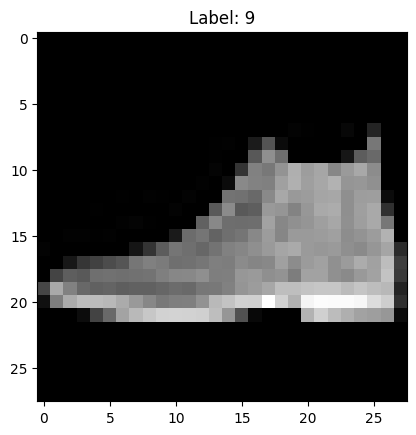

In [51]:
i = 0  # change index to view different images
plt.imshow(train_images[i], cmap='gray')
plt.title(f"Label: {train_labels[i]}")
plt.show()

In [52]:
class FashionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        image = torch.tensor(image).view(-1)
        label = torch.tensor(self.labels[idx]).long()
        return image, label

dataset = FashionDataset(train_images, train_labels)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

Train size: 7000, Test size: 3000


In [53]:
class FashionNN(nn.Module):
    def __init__(self, input_size=784,hidden_size=512, hidden_size1=252, hidden_size2=128,hidden_size3=64, output_size=10):
        super (FashionNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.model(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionNN().to(device)

print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

FashionNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=252, bias=True)
    (3): ReLU()
    (4): Linear(in_features=252, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total trainable parameters: 572486


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
class EarlyStopping:
    def __init__(self,patience,min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [56]:
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, device,train_loader, test_loader):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.loss_history = []
        self.val_loss_history = []

    def calculate_val_loss(self):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        return val_loss / len(self.test_loader.dataset)
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for features, labels in self.train_loader:
            features, labels = features.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(features)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * features.size(0)
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        self.loss_history.append(epoch_loss)
        return epoch_loss

    def train(self, num_epochs, early_stopping, scheduler):
        pbar = tqdm(range(num_epochs), desc='Training', unit='epoch')
        for epoch in pbar:
            epoch_loss = self.train_epoch()
            val_loss = self.calculate_val_loss()

            self.val_loss_history.append(val_loss)

            scheduler.step(val_loss)

            pbar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss})
            if early_stopping:
                early_stopping.step(val_loss)
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    break


In [57]:
trainer = ModelTrainer(model, criterion, optimizer, device, train_loader, test_loader)

num_epochs = 50
patience = 5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

trainer.train(num_epochs, early_stopping, scheduler)

loss_history = trainer.loss_history
val_loss_history = trainer.val_loss_history

Training:  30%|███       | 15/50 [00:09<00:21,  1.62epoch/s, Train Loss=0.223, Val Loss=0.494]

Early stopping triggered


In [58]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 84.20%


              precision    recall  f1-score   support

           0       0.78      0.86      0.82       294
           1       0.96      0.96      0.96       277
           2       0.85      0.59      0.70       315
           3       0.86      0.86      0.86       338
           4       0.64      0.85      0.73       288
           5       0.90      0.95      0.92       290
           6       0.66      0.61      0.63       284
           7       0.94      0.87      0.91       313
           8       0.99      0.95      0.97       294
           9       0.91      0.93      0.92       307

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000



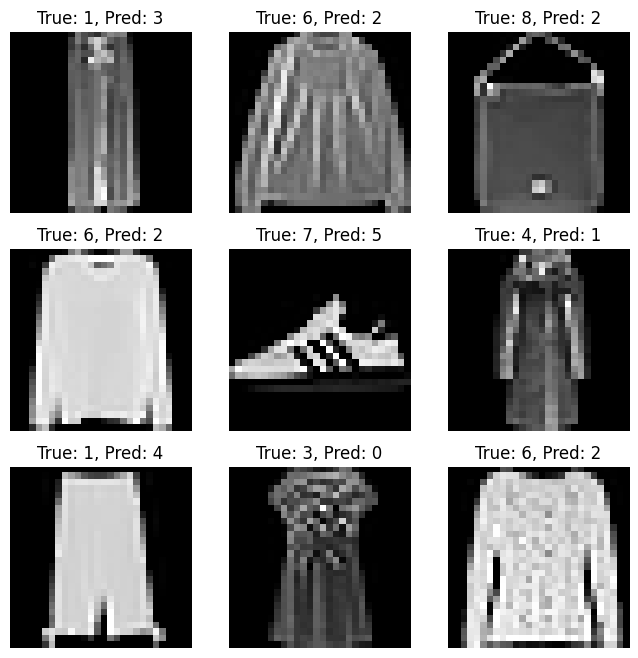

In [59]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
misclassified = []

model.eval()
with torch.no_grad():
    for idx in range(len(test_dataset)):
        image, label = test_dataset[idx]
        img_device = image.to(device).unsqueeze(0)
        output = model(img_device)
        _, pred = torch.max(output, 1)
        if pred.item() != int(label):
            misclassified.append((image, int(label), int(pred.item())))
        if len(misclassified) >= 9:
            break

if len(misclassified) == 0:
    print("All test samples classified correctly.")
else:
    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < len(misclassified):
            image, true_label, pred_label = misclassified[i]
            ax.imshow(image.cpu().view(28, 28), cmap='gray')
            ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    print(classification_report(all_labels, all_preds))
    plt.show()